In [326]:
from __future__ import division
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile

import numpy as np
import pandas as pd

import cPickle as pickle

import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import src.metadata_handler as mdh
import src.clean_db as cdb
import src.data_pipeline as dpl
import src.path_handler as ph

%autoreload 2

In [50]:
# load SFrame
def get_data():
    pass

    
def load_data():
    pass
    

In [55]:
# Create Model
def create_model(X,y):

    rf = RF(n_estimators=60, criterion='gini', max_depth=200, 
          min_samples_split=2, min_samples_leaf=1, 
          min_weight_fraction_leaf=0.0, max_features=600, 
          max_leaf_nodes=None, min_impurity_split=1e-07, 
          bootstrap=True, oob_score=False, n_jobs=2, 
          random_state=None, verbose=0, warm_start=False, 
          class_weight=None)

    rf_modl = rf.fit(X,y)
    return rf_modl

In [56]:
model = create_model(X,y)

In [161]:
# run / eval model
def eval_model(model, X_test, y_test):
    # Modify for web app (or create new function)
    # to predict one photo
    def crossval(score_type):
        try: score = cross_val_score(model, X_test, y_test,
                            cv = 5, scoring= score_type)
        except: score = 'invalid metric'

        return score
    
    print "accuracy : ", crossval('accuracy')
    print "precision: ", crossval('precision')
    print "recall   : ", crossval('recall')
    print "- logloss: ", crossval('neg_log_loss')

In [57]:
run_model(model,X_test,y_test)

The test set contains 65 deer, out of 122 entries. The set is 53.2786885246% deer
accuracy :  [ 0.44        0.44        0.41666667  0.66666667  0.41666667]
precision:  [ 0.41666667  0.57142857  0.35714286  0.58333333  0.5       ]
recall   :  [ 0.38461538  0.53846154  0.23076923  0.46153846  0.61538462]
- logloss:  [-0.74832746 -0.8359539  -0.93367259 -0.77683873 -0.82345745]


# TENSORFLOW 
### (thanks http://www.kernix.com/blog/)

In [59]:
model_dir = 'imagenet'
images_dir = 'data/second_sample'
list_images = []
for p, dirs, files in os.walk(images_dir):
    for ff in files:
        if re.search('jpg|JPG', ff):
            list_images.append(p+'/'+ff)

In [60]:
def create_graph():
    with gfile.FastGFile(os.path.join(
        model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')

In [61]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

        for ind, image in enumerate(list_images):
            if (ind%50 == 0):
                print('Processing %s...' % (image))
            if not gfile.Exists(image):
                tf.logging.fatal('File does not exist %s', image)

            image_data = gfile.FastGFile(image, 'rb').read()

            predictions = sess.run(next_to_last_tensor,
                                {'DecodeJpeg/contents:0': image_data})
            features[ind,:] = np.squeeze(predictions)
            labels.append(re.split('_\d+',image.split('/')[1])[0])

    return features, labels

In [62]:
features,labels = extract_features(list_images)

Processing data/second_sample/BC Kettles/Site 1/April 2015/PICT0021.JPG...
Processing data/second_sample/BC Kettles/Site 1/January 2015/PICT0174.JPG...
Processing data/second_sample/BC Kettles/Site 3/April 2015/EK000055.jpg...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-1/11.22.14-2.1.15/01080241.JPG...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-1/11.22.14-2.1.15/01140341.JPG...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-1/11.22.14-2.1.15/01210441.JPG...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-1/2.1.15-4.11.15/02040454.JPG...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-1/2.1.15-4.11.15/02200774.JPG...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-1/2.1.15-4.11.15/03100936.JPG...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-2/11.22.14-4.11.15/PICT0107.JPG...
Processing data/second_sample/Hope Mountain/Hope Mountain-2015-2/11.22.14-4.11.15/PICT0243.JPG..

In [63]:
features[:3]

array([[ 0.28252327,  1.48760569,  0.        , ...,  0.12448382,
         0.12246145,  0.        ],
       [ 0.1745436 ,  1.41192591,  0.10526261, ...,  0.01048298,
         0.3493064 ,  0.27443966],
       [ 0.15180936,  1.12407768,  0.13523309, ...,  0.00698394,
         0.30669007,  0.36527279]])

# preparing my database ... more ... again .... (T_T)

In [149]:
# Borrowing csv from FSM
cdb.main('data/FirstStupidModel/raw_metadata.json', 'data/FirstStupidModel/metadata.csv')

raw_df = pd.read_csv('data/FirstStupidModel/metadata.csv')

# raw_df.head().T

In [215]:
df = raw_df
df.loc[df.keywords == '[]', 'keywords'] = "not_provided"

d1 = {'ungulate':["[u'mule deer']", "[u'White-tailed deer']", "[u'elk']"],
      'feline':["[u'bobcat']", "[u'Canada lynx']"],
      'hare':["[u'snowshoe hare']"],
      'canine':["[u'coyote']", "[u'domestic dog']"],
      'small': ["[u'mouse']", "[u'red squirrel']", "[u'Robin']", "[u'bird']",
                "[u'northern flying squirrel']", "[u'Squirrel (unidentified)']", 
                "[u'chipmunk']", "[u'Squirrel']"],
      'other':["[u'unidentified']", "[u'Camera Check']", "[u'striped skunk']",
               "[u'Wolverine']", "not_provided", "[u'cougar']"]}

d2 = {}
for key,value in d1.iteritems():
    for item in value:
        d2[item] = key


labels = df.keywords.map(d2)

print "label vaues: \n",labels.value_counts()
print "\ntemp size: ",labels.size



label vaues: 
hare        928
ungulate    193
small       104
other       101
canine       95
feline       43
Name: keywords, dtype: int64

temp size:  1464


In [370]:
print df.file_path[df.keywords == 'not_provided']
print df.file_path[938]

938    data/second_sample/Hope Mountain/Hope Mountain...
Name: file_path, dtype: object
data/second_sample/Hope Mountain/Hope Mountain-2015-2/11.22.14-4.11.15/PICT0160.JPG


# Define Plots

In [381]:
def plot_confusion_matrix(y_true,y_pred):
    cm_array = confusion_matrix(y_true,y_pred)
    true_labels = np.unique(y_true)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Number of images', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels)+1)
    ytick_marks = np.arange(len(pred_labels)+1)
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 8
    plt.rcParams["figure.figsize"] = fig_size

In [382]:
def plot_matrix(array):
    cm_array = array
    true_labels = np.unique(y_test)
    pred_labels = np.unique(y_pred)
    plt.imshow(cm_array, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix", fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Percent True', rotation=270, labelpad=30, fontsize=12)
    xtick_marks = np.arange(len(true_labels)+1)
    ytick_marks = np.arange(len(pred_labels)+1)
    plt.xticks(xtick_marks, true_labels, rotation=90)
    plt.yticks(ytick_marks,pred_labels)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 8
    plt.rcParams["figure.figsize"] = fig_size

# Model fsm2

In [404]:
def create_SVC_model(F,L):
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(F,L, test_size=0.2, random_state=80)

    svm = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
    model = svm.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, X_test, y_test, y_pred

In [405]:
F = features[(labels != 'hare').values]
L = labels[labels!='hare']

model, X_test, y_test, y_pred = create_SVC_model(F,L)

In [406]:
eval_model(model, X_test, y_test)

accuracy :  [ 0.83333333  0.86363636  0.95238095  0.9047619   0.85      ]
precision:  invalid metric
recall   :  invalid metric
- logloss:  invalid metric


In [407]:
y_test.value_counts()

ungulate    40
canine      22
small       21
other       14
feline      11
Name: keywords, dtype: int64

In [408]:
# Manually put labels in order
alph_val_count = np.array([[22, 11, 14, 21, 40]])
percent_matrix = confusion_matrix(y_test,y_pred)*100/alph_val_count.T

In [409]:
print "Total value counts: \n",labels.value_counts()
print "\nTest set value counts:\n",y_test.value_counts()
print '\nTest Confusion Matrix:\n',confusion_matrix(y_test,y_pred)
print '\nPercentage (sort of)\n', percent_matrix
print '\n'

Total value counts: 
hare        928
ungulate    193
small       104
other       101
canine       95
feline       43
Name: keywords, dtype: int64

Test set value counts:
ungulate    40
canine      22
small       21
other       14
feline      11
Name: keywords, dtype: int64

Test Confusion Matrix:
[[22  0  0  0  0]
 [ 0 11  0  0  0]
 [ 0  0 12  1  1]
 [ 0  0  0 21  0]
 [ 0  0  0  0 40]]

Percentage (sort of)
[[ 100.            0.            0.            0.            0.        ]
 [   0.          100.            0.            0.            0.        ]
 [   0.            0.           85.71428571    7.14285714    7.14285714]
 [   0.            0.            0.          100.            0.        ]
 [   0.            0.            0.            0.          100.        ]]




In [410]:
# plot_confusion_matrix(y_test, y_pred)

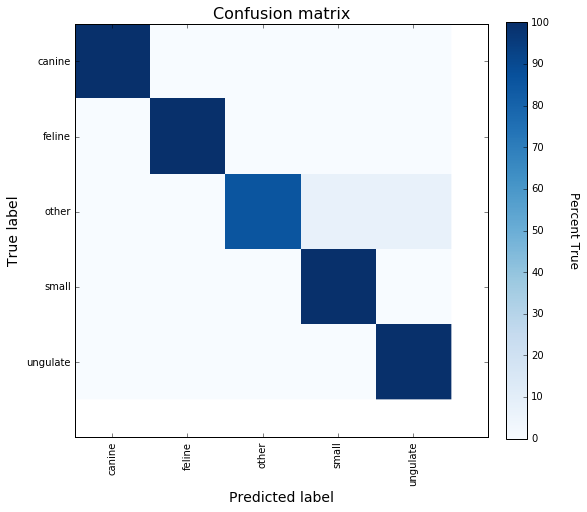

In [411]:
plot_matrix(percent_matrix)

# With Hare (unbalanced)

In [412]:
F = features
L = labels
model, X_test, y_test, y_pred = create_SVC_model(F,L)

# Manually order count_values :(
A = np.array([[16,5,175,24,27,46]])
percent_matrix = confusion_matrix(y_test,y_pred)*100/A.T

In [416]:
print "Total value counts: \n",labels.value_counts()
print "\nTest set value counts:\n",y_test.value_counts()
print '\nTest Confusion Matrix:\n',confusion_matrix(y_test,y_pred)
print '\nPercentage (sort of)\n', np.round(percent_matrix, decimals=2)
print '\n'

Total value counts: 
hare        928
ungulate    193
small       104
other       101
canine       95
feline       43
Name: keywords, dtype: int64

Test set value counts:
hare        175
ungulate     46
small        27
other        24
canine       16
feline        5
Name: keywords, dtype: int64

Test Confusion Matrix:
[[ 16   0   0   0   0   0]
 [  0   5   0   0   0   0]
 [  0   1 166   3   1   4]
 [  0   0  12   9   2   1]
 [  0   0   3   0  24   0]
 [  0   0   7   0   0  39]]

Percentage (sort of)
[[ 100.      0.      0.      0.      0.      0.  ]
 [   0.    100.      0.      0.      0.      0.  ]
 [   0.      0.57   94.86    1.71    0.57    2.29]
 [   0.      0.     50.     37.5     8.33    4.17]
 [   0.      0.     11.11    0.     88.89    0.  ]
 [   0.      0.     15.22    0.      0.     84.78]]




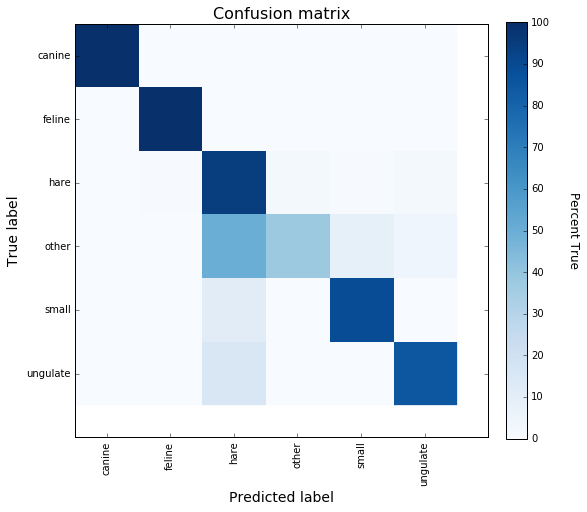

In [415]:
plot_matrix(percent_matrix)

#### ToDo

* be sure metadata is not being used by CNN
* Try dropping 'other' group
* try including (some of) 'hare'
* Try replacing 'small' with 'hare'
* Try running model on one set of cameras/positions
    + Then test with a new camera